# Exercise 07: Heatmap

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable 
%matplotlib inline

In [2]:
con = sqlite3.connect("../data/checking-logs.sqlite")
cur = con.cursor()

- Analyze only the users, not the admins.

In [3]:
commit_data =  pd.read_sql("""
                SELECT uid, timestamp as commit_time FROM checker
                WHERE uid LIKE 'user%'
            """, 
            con, parse_dates='commit_time')
commit_data

,uid,commit_time
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


In [4]:
commit_data['commit_date'] = commit_data.commit_time.dt.date
commit_data['commit_hour'] = commit_data.commit_time.dt.hour
commit_data['commit_weekday'] = commit_data.commit_time.dt.weekday
commit_data.commit_date = pd.to_datetime(commit_data.commit_date)
commit_data

,uid,commit_time,commit_date,commit_hour,commit_weekday
0,user_4,2020-04-17 05:19:02.744528,2020-04-17,5,4
1,user_4,2020-04-17 05:22:35.249331,2020-04-17,5,4
2,user_4,2020-04-17 05:22:45.549397,2020-04-17,5,4
3,user_4,2020-04-17 05:34:14.691200,2020-04-17,5,4
4,user_4,2020-04-17 05:34:24.422370,2020-04-17,5,4
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,2020-05-21,20,3
3203,user_1,2020-05-21 20:22:41.785725,2020-05-21,20,3
3204,user_1,2020-05-21 20:22:41.877806,2020-05-21,20,3
3205,user_1,2020-05-21 20:37:00.129678,2020-05-21,20,3


- Preparing hour data

In [5]:
user_hour = commit_data.groupby(['uid','commit_hour'], as_index = False).commit_date.count() \
                        .sort_values('commit_date', ascending=False) \
                        .rename(columns={'commit_date':'count'})
user_hour

,uid,commit_hour,count
283,user_4,21,86
260,user_31,11,70
282,user_4,20,53
230,user_29,19,45
186,user_25,21,43
...,...,...,...
259,user_31,9,1
33,user_12,18,1
21,user_11,23,1
30,user_12,15,1


In [6]:
total_commits = user_hour. \
                groupby('uid', as_index = False)['count'].sum(). \
                sort_values('count', ascending = False).uid
order_columns = list(total_commits)

In [7]:
total_commits

26     user_4
6     user_14
12     user_2
18    user_25
11    user_19
19    user_26
13    user_20
25    user_31
2     user_10
23     user_3
22    user_29
5     user_13
21    user_28
17    user_24
4     user_12
29     user_8
1      user_1
14    user_21
24    user_30
10    user_18
9     user_17
8     user_16
20    user_27
7     user_15
27     user_6
3     user_11
28     user_7
15    user_22
16    user_23
0      user_0
Name: uid, dtype: object

In [8]:
# заполнить пропуски если нет коммитов в определенный час
for user in user_hour.uid.unique():
    for hour in range(0,24):
        if hour not in list(user_hour[user_hour.uid == user].commit_hour):
            user_hour.loc[len(user_hour)] = [user, hour, 0]


In [9]:
hour_data = pd.pivot(user_hour, index = 'commit_hour', columns = 'uid', values = 'count').reindex(columns=order_columns)
hour_data

uid,user_4,user_14,user_2,user_25,user_19,user_26,user_20,user_31,user_10,user_3,...,user_17,user_16,user_27,user_15,user_6,user_11,user_7,user_22,user_23,user_0
commit_hour,,,,,,,,,,,,,,,,,,,,,
0,0,4,0,0,0,4,0,2,0,0,...,0,0,0,0,2,0,0,0,0,0
1,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,13,0,2,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,3,6,0,0,10,2,0,3,0,...,1,0,0,0,0,0,0,0,0,0
8,0,6,0,0,0,5,2,0,9,6,...,2,0,0,0,0,0,1,0,1,0


- Preparing weekday data

In [10]:
user_weekday = commit_data.groupby(['uid','commit_weekday'], as_index = False).commit_date.count() \
                        .sort_values('commit_date', ascending=False) \
                        .rename(columns={'commit_date':'count'})
user_weekday

,uid,commit_weekday,count
50,user_2,1,131
125,user_4,3,108
57,user_20,3,96
120,user_31,5,90
23,user_14,1,87
...,...,...,...
75,user_24,6,1
101,user_29,4,1
83,user_26,1,1
112,user_30,2,1


In [11]:
for user in user_weekday.uid.unique():
    for day in range(0,7):
        if day not in list(user_weekday[user_weekday.uid == user].commit_weekday):
            user_weekday.loc[len(user_weekday)] = [user, day, 0]

In [12]:
weekday_data = pd.pivot(user_weekday, index = 'commit_weekday', columns = 'uid', values = 'count').reindex(columns=order_columns)
weekday_data

uid,user_4,user_14,user_2,user_25,user_19,user_26,user_20,user_31,user_10,user_3,...,user_17,user_16,user_27,user_15,user_6,user_11,user_7,user_22,user_23,user_0
commit_weekday,,,,,,,,,,,,,,,,,,,,,
0,35,50,24,14,7,0,23,5,0,46,...,8,10,0,0,1,0,0,2,0,3
1,86,87,131,44,9,1,0,0,16,11,...,4,5,0,0,0,0,5,3,0,0
2,33,0,32,15,0,34,8,0,37,0,...,1,0,0,0,4,0,3,0,0,0
3,108,17,4,40,78,51,96,7,77,7,...,17,14,15,5,2,0,0,2,6,0
4,61,0,0,10,10,2,7,35,1,59,...,0,0,0,0,0,0,0,0,0,0
5,0,79,31,66,21,16,3,90,4,3,...,32,0,0,4,2,0,0,0,0,0
6,45,26,13,44,51,69,28,7,2,8,...,0,31,27,20,9,8,0,1,0,0


- Heatmap

In [13]:
hours = range(0,24)
weekdays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

- You can choose a color palette for both graphs.
- Use the table checker for your query.
- Use the absolute values of the commits, not the averages.
- Sort the dataframes by the total number of commits made by a user.

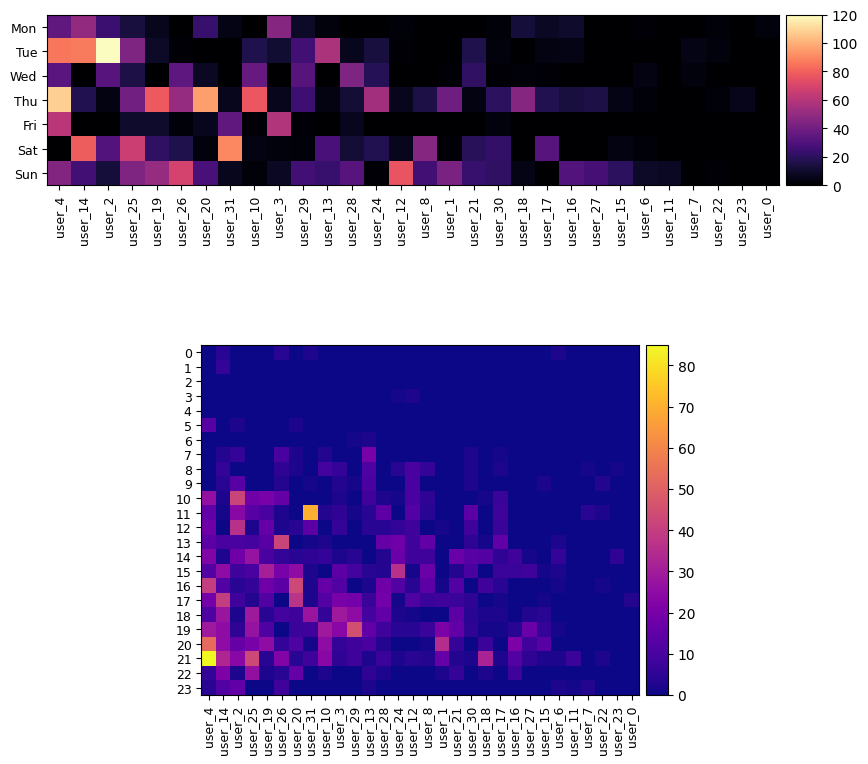

In [14]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
# weekday heatmap
im_w = ax[0].imshow(weekday_data, cmap = 'magma', vmin=0, vmax=120)
ax[0].set_xticks(range(len(order_columns)), labels = order_columns, rotation = 90, fontsize=9)
ax[0].set_yticks(range(len(weekdays)), labels = weekdays, fontsize = 9)
divider = make_axes_locatable(ax[0])
cax_w = divider.append_axes("right", size="5%", pad=0.07)
fig.colorbar(im_w, cax=cax_w)

# hour heatmap
im = ax[1].imshow(hour_data, cmap = 'plasma', vmin=0, vmax=85)
ax[1].set_xticks(range(len(order_columns)), labels = order_columns, rotation = 90, fontsize=9)
ax[1].set_yticks(range(len(hours)), labels = hours, fontsize = 9)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.07)
fig.colorbar(im, cax=cax)

plt.show()

### Which user has the most commits on Tuesday?

# Answer: user_2

### Which user has the most commits on Thursday?

# Answer: user_4

### On which weekday do users not like to make a lot of commits?

# Answer: Fri

### Which user made the largest number of commits at which hour?

# Answer: user_4, 21

In [15]:
con.close()